In [181]:
import pandas as pd
import requests
from time import sleep
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from src.core.votacao import TipoVoto
import seaborn as sns
from scipy.stats import ttest_ind_from_stats

In [57]:
projs = pd.read_excel(r"./projetos_selecionados.xlsx")
projs

,tipo,código,ano,tema,ementa,orientação
0,PEC,6,2019,reforma da previdência,"Modifica o sistema de previdência social, esta...",1
1,PL,3418,2021,fundebe,"Altera a Lei nº 14.113, de 25 de dezembro de 2...",1
2,PL,5829,2019,energia renovável,NOVA EMENTA: Institui o marco legal da microge...,1
3,PL,3179,2012,homeschooling,"Altera as Leis nºs 9.394, de 20 de dezembro de...",1


# Dados


In [125]:
df_parls = pd.read_csv("./data/parlamentares.csv")
df_parls["id_parl"] = [str(id_parl) for id_parl in df_parls["id_parl"]]
df_parls=df_parls.drop_duplicates("id_parl")

df_dim_prof = pd.read_excel("./data/dim_profissoes_ficha.xlsx")

df_parls_profs = pd.read_csv("./data/profissoes.csv")

df_profs_d = df_parls_profs[["id_parl", "cod_tipo_profissao", "titulo"]].merge(
    df_dim_prof[["codTipoProfissao", "is_empresario"]],
    left_on="cod_tipo_profissao",
    right_on="codTipoProfissao",
)
df_profs_d = (
    df_profs_d.join(pd.get_dummies(df_profs_d["cod_tipo_profissao"]))
    .groupby("id_parl")
    .max(numeric_only=True)
    .reset_index()
)

df_profs_d["id_parl"] = [str(id_parl) for id_parl in df_profs_d["id_parl"]]

df_parls = df_parls.merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")

In [126]:
df_props = pd.DataFrame()
df_autores = pd.DataFrame()
df_votacoes = pd.DataFrame()
df_votos = pd.DataFrame()
df_orientacoes = pd.DataFrame()

for idx in projs.index:
    nome_tema = projs.loc[idx, "tema "]

    df_tema = pd.read_csv(f"./data/{nome_tema}/projetos.csv")
    df_tema["tema"] = nome_tema
    df_props = pd.concat([df_props, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/autores.csv")
    df_tema["tema"] = nome_tema
    df_autores = pd.concat([df_autores, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/votacoes.csv")
    df_tema["tema"] = nome_tema
    df_votacoes = pd.concat([df_votacoes, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/votos.csv")
    df_tema["tema"] = nome_tema
    df_votos = pd.concat([df_votos, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/orientacoes.csv").dropna(
        subset="orientacao_voto"
    )
    df_tema["tema"] = nome_tema
    df_orientacoes = pd.concat([df_orientacoes, df_tema])

df_votos["id_parl"] = [str(id_autor) for id_autor in df_votos["id_parl"]]
df_votos = df_votos.drop_duplicates(["id_parl", "id_votacao"])

df_autores["id_autor"] = [str(id_autor) for id_autor in df_autores["id_autor"]]

In [164]:
df_numeric = (
    df_parls_gov.join(pd.get_dummies(df_parls_gov["sigla_uf"], dtype=int, prefix="uf"))
    .join(pd.get_dummies(df_parls_gov["sigla_partido"], dtype=int, prefix="partido"))
    .reset_index(drop=True)
)

df_numeric.drop(
    ["sigla_partido", "sigla_uf"],
    axis=1,
    inplace=True,
)

## Governismo

In [127]:
df_ori_gov = df_orientacoes[
    df_orientacoes["sigla_partido_bloco"] == "Governo"
].reset_index(drop=True)
df_ori_gov["v_trat"] = df_ori_gov["orientacao_voto"].apply(
    lambda x: TipoVoto[x.upper()].value
)

In [128]:
df_v_m_g = df_votos.merge(df_ori_gov, on="id_votacao")
df_v_m_g["ori_g"] = df_v_m_g["voto_trat"] * df_v_m_g["v_trat"]

In [129]:
df_gov = (
    df_v_m_g.join(pd.get_dummies(df_v_m_g["ori_g"]))
    .groupby("id_parl")
    .agg({1: "sum", -1: "sum"})
    .reset_index()
)
df_gov['governismo'] = df_gov[1] / (df_gov[1] + df_gov[-1])

In [130]:
df_parls_gov = df_parls.merge(df_gov[["id_parl", "governismo"]], on="id_parl")
df_parls_gov = df_parls_gov[
    ["id_parl", "sigla_partido", "sigla_uf", "is_empresario", "governismo"]
].reset_index(drop=True)

---


# Descritivas


In [180]:
df_num_e = df_numeric[df_numeric["is_empresario"] == 1].describe().T
df_num_ne = df_numeric[df_numeric["is_empresario"] == 0].describe().T
df_num_e.join(df_num_ne, lsuffix="_empr", rsuffix="_nao_empr")[
    [
        "mean_empr",
        "std_empr",
        "mean_nao_empr",
        "std_nao_empr",
    ]
]



,mean_empr,std_empr,mean_nao_empr,std_nao_empr
is_empresario,1.000000,0.000000,0.000000,0.000000
governismo,0.871163,0.196847,0.769717,0.258157
uf_AC,0.000000,0.000000,0.024324,0.154263
uf_AL,0.015873,0.125316,0.018919,0.136423
uf_AM,0.010582,0.102595,0.016216,0.126477
uf_AP,0.005291,0.072739,0.021622,0.145642
uf_BA,0.084656,0.279109,0.070270,0.255948
uf_CE,0.058201,0.234745,0.040541,0.197490
uf_DF,0.021164,0.144313,0.013514,0.115616
uf_ES,0.021164,0.144313,0.021622,0.145642


In [208]:
df_empres_by_partido = (
    df_parls.groupby("sigla_partido")
    .agg({"id_parl": "count", "is_empresario": "sum"})
    .rename({"id_parl": "total", "is_empresario": "empresarios"}, axis=1)
    .sort_values("empresarios", ascending=False)
)
df_empres_by_partido["%"] = (
    round(df_empres_by_partido["empresarios"] / df_empres_by_partido["total"] * 100, 1)
)
df_empres_by_partido.loc["Total"] = df_empres_by_partido.sum()
df_empres_by_partido = df_empres_by_partido.astype({'total': 'int32', "empresarios": "int32"})
df_empres_by_partido

,total,empresarios,%
sigla_partido,,,
PP,89,42,47.2
MDB,91,31,34.1
PSD,78,29,37.2
PL,55,20,36.4
PR,44,19,43.2
PT,89,14,15.7
UNIÃO,36,13,36.1
DEM,47,13,27.7
PODE,31,13,41.9


In [148]:
df_props_tema = df_props.groupby("tema").agg({'id_prop':"count"}).rename({'id_prop': "Proposições"}, axis=1)
df_votacoes_tema = df_votacoes.groupby('tema').agg({'id_votacao': "count"}).rename({'id_votacao': "Votações"}, axis=1)
df_vots_tema = (
    df_votos.groupby(["tema", "id_votacao"])
    .agg({"id_parl": "count"})
    .reset_index()
    .groupby("tema")
    .agg({"id_votacao": "count", "id_parl": "sum"})
    .rename({'id_votacao': "Votações Nominais", "id_parl":"Votos"}, axis=1)
)
df_geral_amostra = df_props_tema.join([df_votacoes_tema, df_vots_tema])
df_geral_amostra

,Proposições,Votações,Votações Nominais,Votos
tema,,,,
energia renovável,101,18,3,1357
fundebe,31,17,4,1589
homeschooling,61,23,12,4055
reforma da previdência,553,383,46,19509


---


# Pareamento


In [149]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

In [151]:
psm = PsmPy(df_numeric, treatment="is_empresario", indx="id_parl")

psm.logistic_ps(balance=True)

psm.knn_matched(
    matcher="propensity_logit", replacement=False, caliper=None, drop_unmatched=True
)

/home/acacio/.local/lib/python3.10/site-packages/psmpy/psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


In [152]:
matched = []
for treat, control in zip(psm.matched_ids["id_parl"], psm.matc378hed_ids["matched_ID"]):
    matched.append(treat)
    matched.append(control)
print(len(matched))

378


## calcular rice com matched


In [197]:
def plotar(df_rice):
    ax = sns.boxplot(data=df_rice, x="tema", y="rice", hue="is_empresario")
    ax.set(ylabel="Índice Rice", xlabel="Tema")
    ax.set_xticklabels(["Energia\nRenovável", "FUNDEB","Homeschooling","Reforma da\nPrevidência"])
    labels=["Não Empresário", "Empresário"]
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels)
    plt.show()

count      mean       std
tema                   is_empresario                           
energia renovável      0                  3  0.784094  0.240006
                       1                  3  0.808419  0.219908
fundebe                0                  4  0.749252  0.210864
                       1                  4  0.779436  0.147402
homeschooling          0                 12  0.589179  0.122240
                       1                 12  0.633763  0.118667
reforma da previdência 0                 46  0.738944  0.186960
                       1                 46  0.756441  0.183270

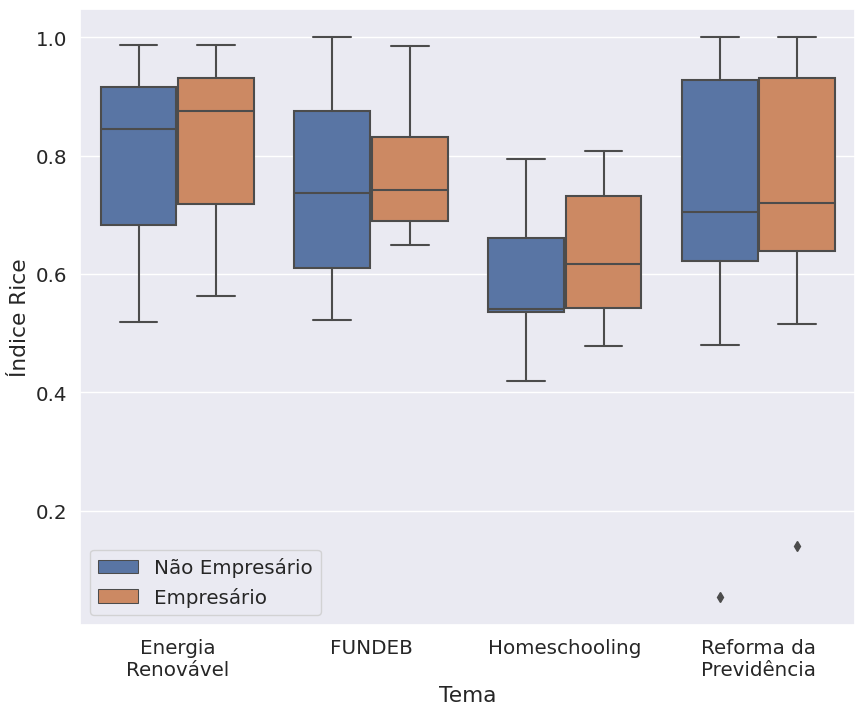

In [210]:
df_final = (
    df_votos[["id_parl", "sigla_partido", "id_votacao", "voto_trat", "tema"]]
    .merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")
    .reset_index(drop=True)
)
# calcular rice
df_rice_com = (
    df_final[df_final["id_parl"].isin(matched)]
    .join(pd.get_dummies(df_final["voto_trat"]))
    .groupby(["tema", "id_votacao", "is_empresario"])
    .agg(({-1: "sum", 1: "sum"}))
    .reset_index()
)
df_rice_com["rice"] = abs(df_rice_com[1] - df_rice_com[-1]) / (df_rice_com[1] + df_rice_com[-1])
df_rice_com_g = df_rice_com.groupby(["tema", "is_empresario"])["rice"].agg(["count", "mean", "std"])
display(df_rice_com_g)
plotar(df_rice_com)

## Rice sem pareamento

count      mean       std
tema                   is_empresario                           
energia renovável      0                  3  0.665049  0.384583
                       1                  3  0.809404  0.218336
fundebe                0                  4  0.657210  0.302955
                       1                  4  0.779436  0.147402
homeschooling          0                 12  0.455136  0.251130
                       1                 12  0.633763  0.118667
reforma da previdência 0                 46  0.561660  0.281919
                       1                 46  0.756441  0.183270

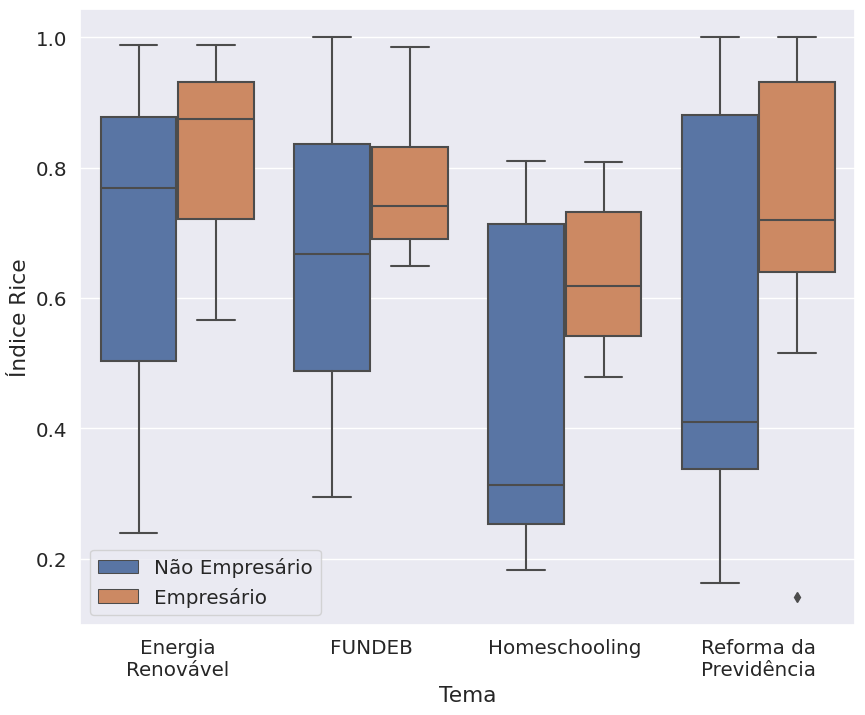

In [209]:
# calcular rice
df_rice_sem= (
    df_final.join(pd.get_dummies(df_final["voto_trat"]))
    .groupby(["tema", "id_votacao", "is_empresario"])
    .agg(({-1: "sum", 1: "sum"}))
    .reset_index()
)
df_rice_sem["rice"] = abs(df_rice_sem[1] - df_rice_sem[-1]) / (df_rice_sem[1] + df_rice_sem[-1])
df_rice_sem_g = df_rice_sem.groupby(["tema", "is_empresario"])["rice"].agg(["count", "mean", "std"])
display(df_rice_sem_g)
plotar(df_rice_sem)

## calcular rice com matching em votações divergentes

In [354]:
df_rice_votacoes = (
    df_votos.join(pd.get_dummies(df_votos["voto_trat"]))
    .groupby("id_votacao")
    .agg({1: "sum", -1: "sum"})
    .reset_index()
)

df_rice_votacoes["rice"] = abs(df_rice_votacoes[1] - df_rice_votacoes[-1]) / (
    df_rice_votacoes[1] + df_rice_votacoes[-1]
)

In [362]:
votacoes_divergentes = list(df_rice_votacoes.query("rice < .95")['id_votacao'])

In [369]:
df_final = (
    df_votos[df_votos["id_votacao"].isin(votacoes_divergentes)][
        ["id_parl", "sigla_partido", "id_votacao", "voto_trat", "tema"]
    ]
    .merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")
    .reset_index(drop=True)
)
# calcular rice
df_rice = (
    df_final[df_final["id_parl"].isin(matched)]
    .join(pd.get_dummies(df_final["voto_trat"]))
    .groupby(["tema", "id_votacao", "is_empresario"])
    .agg(({-1: "sum", 1: "sum"}))
    .reset_index()
)
df_rice["rice"] = abs(df_rice[1] - df_rice[-1]) / (df_rice[1] + df_rice[-1])
df_rice_g = df_rice.groupby(["tema", "is_empresario"])["rice"].agg(["count", "mean", "std"])
display(df_rice_g)

count      mean       std
tema                   is_empresario                           
energia renovável      0                  3  0.781479  0.207533
                       1                  3  0.808419  0.219908
fundebe                0                  4  0.743108  0.195308
                       1                  4  0.779436  0.147402
homeschooling          0                 12  0.625489  0.105407
                       1                 12  0.633763  0.118667
reforma da previdência 0                 42  0.721311  0.183010
                       1                 42  0.735656  0.178063

# PLOT
